<a href="https://colab.research.google.com/github/CKeibel/DeepLearning_vs_DeepReinforcementLearning/blob/main/Deep_Q_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop

import gym

import numpy as np

# **Prepocessing**
Stable Baselines

https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py

In [4]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [22]:
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]

In [18]:
from collections import deque
from gym import spaces

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

In [68]:
def make_env(env_name):
  env = gym.make(env_name)
  if 'FIRE' in env.unwrapped.get_action_meanings():
    env = FireResetEnv(env)
  env = FrameStack(env, 4)
  return env

In [69]:
game = "MsPacman-v0"

In [70]:
env = make_env(game)

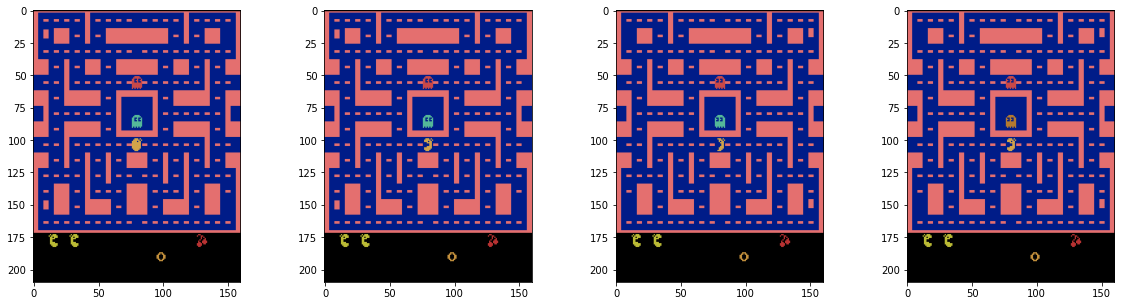

In [71]:
from matplotlib import pyplot as plt

env.reset()
for episode in range(1, 5):
  next_state, reward, done, _ = env.step(2)
state = np.array(next_state)


fig, axs = plt.subplots(1,4, figsize=(20, 5))
axs[0].imshow(state[:, :, :3])
axs[1].imshow(state[:, :, 3:6])
axs[2].imshow(state[:, :, 6:9])
axs[3].imshow(state[:, :, 9:12])
plt.show()

TODO:


*   finishing Wrappers
*   create env
* create NN and Targetnetwork
* Replay Buffer
* Experience Replay
* get_action -> Epsilon Greedy
* train loop
* save weights
* load weight
* play game
